# 02 - Improved Logistic Regression

We will attempt imporving the logistic regression by creatring new features and by using regularization.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.utils import shuffle

In [2]:
raw_df = pd.read_csv('sampleclass.csv')
raw_df = shuffle(raw_df)
raw_df.head()

X1        X2  Y
107 -0.22350 -0.078947  1
1   -0.34793  0.470760  1
88  -0.39862  0.266080  1
199 -0.11164  0.548830  1
9   -0.29724  0.347950  1

In [3]:
raw_df.describe()

X1          X2           Y
count  211.000000  211.000000  211.000000
mean    -0.130245   -0.059744    0.502370
std      0.200516    0.314750    0.501183
min     -0.596770   -0.657900    0.000000
25%     -0.287905   -0.313890    0.000000
50%     -0.130300   -0.052924    1.000000
75%      0.013825    0.192690    1.000000
max      0.297240    0.573390    1.000000

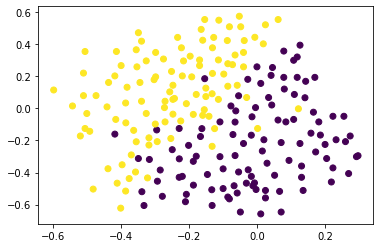

In [4]:
plt.scatter(raw_df["X1"], raw_df["X2"], c=raw_df["Y"])

In [5]:
raw_df.shape

(211, 3)

In [6]:
raw_df['X1Squared'] = raw_df['X1']**2
raw_df['X2Squared'] = raw_df['X2']**2
raw_df['X1X2'] = raw_df['X1']*raw_df['X2']
raw_df['X1Cubed'] = raw_df['X1']**3
raw_df['X2Cubed'] = raw_df['X2']**3
raw_df['X1X2Squared'] = raw_df['X1']*raw_df['X2']**2
raw_df['X1SquaredX2'] = raw_df['X1']**2*raw_df['X2']

In [7]:
X = raw_df[['X1', 'X2', 'X1Squared', 'X2Squared', 'X1X2','X1Cubed','X2Cubed','X1X2Squared','X1SquaredX2']]
X.shape

(211, 9)

In [8]:
Y = raw_df[['Y']]

In [9]:
Y.shape

(211, 1)

In [10]:
X_train = X[:-20]
X_test = X[-20:]
Y_train = Y[:-20]
Y_test = Y[-20:]

In [11]:
X_train.shape

(191, 9)

In [12]:
Y_train.shape

(191, 1)

In [13]:
X_test.shape

(20, 9)

In [14]:
Y_test.shape

(20, 1)

In [15]:
def make_input_fn(data_df, label_df, num_epochs=2000, shuffle=True, batch_size=512):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(X_train, Y_train)
eval_input_fn = make_input_fn(X_test, Y_test, num_epochs=1, shuffle=False)

A simple linear regression can be extended by constructing polynomial features from the coefficients. In the standard linear regression case, you might have a model that looks like this for two-dimensional data: $\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2$

This is still a linear model: to see this, imagine creating a new set of features $z = [x_1, x_2, x_1 x_2, x_1^2, x_2^2]$ and with this re-labeling of the data, our problem can be written as $\hat{y}(w, z) = w_0 + w_1 z_1 + w_2 z_2 + w_3 z_3 + w_4 z_4 + w_5 z_5$


In [16]:
feature_columns = []
feature_columns.append(tf.feature_column.numeric_column("X1", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X2", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X1Squared", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X2Squared", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X1Cubed", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X2Cubed", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X1X2", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X1X2Squared", dtype=tf.float32))
feature_columns.append(tf.feature_column.numeric_column("X1SquaredX2", dtype=tf.float32))


We will use a linear regression model with Regularization to avoid overfitting. 

A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients.

L1 regularization pushes weights towards exactly zero encouraging a sparse model.

In [17]:

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

#linear_est = tf.estimator.LinearClassifier(
#    feature_columns=feature_columns,
#    optimizer=tf.keras.optimizers.Ftrl(
#      learning_rate=0.01,
#      l1_regularization_strength=0.001
#    ))

#linear_est = tf.estimator.LinearClassifier(
#    feature_columns=feature_columns,
#    optimizer=lambda: tf.keras.optimizers.Ftrl(
#        learning_rate=tf.compat.v1.train.exponential_decay(
#            learning_rate=0.1,
#            global_step=tf.compat.v1.train.get_global_step(),
#            decay_steps=10000,
#            decay_rate=0.96)))

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
print(result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\IVANKR~1\\AppData\\Local\\Temp\\tmpzolc30jx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.rea

C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\IVANKR~1\AppData\Local\Temp\tmpzolc30jx\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.69314736, step = 0
INFO:tensorflow:global_step/sec: 476.193
INFO:tensorflow:loss = 0.46574253, step = 100 (0.211 sec)
INFO:tensorflow:global_step/sec: 714.262
INFO:tensorflow:loss = 0.40417683, step = 200 (0.140 sec)
INFO:tensorflow:global_step/sec: 719.452
INFO:tensorflow:loss = 0.3717561, step = 300 (0.138 sec)
INFO:tensorflow:global_step/sec: 724.62
INFO:tensorflow:loss = 0.35081267, step = 4

C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-07-15T17:03:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\IVANKR~1\AppData\Local\Temp\tmpzolc30jx\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52445s
INFO:tensorflow:Finished evaluation at 2021-07-15-17:03:14
INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, accuracy_baseline = 0.5, auc = 1.0, auc_precision_recall = 1.0, average_loss = 0.16909504, global_step = 2000, label/mean = 0.5, loss = 0.16909504, precision = 1.0, prediction/mean = 0.505905, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\IVANKR~1\AppData\Local\Temp\tmpzolc30jx\model.ckpt-2000
{'accuracy': 1.0, 'accuracy_baseline': 0.5, 'auc': 1.0, 'auc_precision_recall': 1.0, 'average_loss': 0.16909504, 'label/mean': 0.5, 'loss': 0.16909504, 'precision': 1

Our model now has an accuracy of 95%.

INFO:tensorflow:Calling model_fn.


C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\IVANKR~1\AppData\Local\Temp\tmpzolc30jx\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

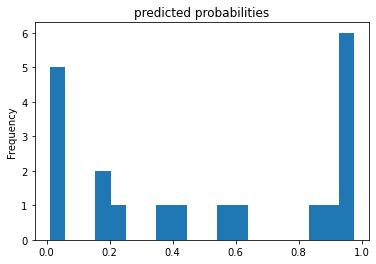

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')


In [19]:
h = .02  # step size in the mesh
# create a mesh to plot in
x1_min = -0.7
x1_max = 0.7
x2_min = -0.7
x2_max = 0.7
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

In [20]:
my_array = np.c_[xx1.ravel(), xx2.ravel()]
data_x = pd.DataFrame(my_array, columns = ['X1','X2']) 
data_x['X1Squared'] = data_x['X1']**2
data_x['X2Squared'] = data_x['X2']**2
data_x['X1X2'] = data_x['X1']*data_x['X2']
data_x['X1Cubed'] = data_x['X1']**3
data_x['X2Cubed'] = data_x['X2']**3
data_x['X1X2Squared'] = data_x['X1']*data_x['X2']**2
data_x['X1SquaredX2'] = data_x['X1']**2*data_x['X2']
data_y = np.zeros((data_x.shape[0],1))
data_x.shape

(4900, 9)

In [21]:
data_x

X1    X2  X1Squared  X2Squared    X1X2   X1Cubed   X2Cubed  \
0    -0.70 -0.70     0.4900     0.4900  0.4900 -0.343000 -0.343000   
1    -0.68 -0.70     0.4624     0.4900  0.4760 -0.314432 -0.343000   
2    -0.66 -0.70     0.4356     0.4900  0.4620 -0.287496 -0.343000   
3    -0.64 -0.70     0.4096     0.4900  0.4480 -0.262144 -0.343000   
4    -0.62 -0.70     0.3844     0.4900  0.4340 -0.238328 -0.343000   
...    ...   ...        ...        ...     ...       ...       ...   
4895  0.60  0.68     0.3600     0.4624  0.4080  0.216000  0.314432   
4896  0.62  0.68     0.3844     0.4624  0.4216  0.238328  0.314432   
4897  0.64  0.68     0.4096     0.4624  0.4352  0.262144  0.314432   
4898  0.66  0.68     0.4356     0.4624  0.4488  0.287496  0.314432   
4899  0.68  0.68     0.4624     0.4624  0.4624  0.314432  0.314432   

      X1X2Squared  X1SquaredX2  
0       -0.343000    -0.343000  
1       -0.333200    -0.323680  
2       -0.323400    -0.304920  
3       -0.313600    -0.286720  
4       -0.303800    -0.269080  
...           ...          ...  
4895     0.277440     0.244800  
4896     0.286688     0.261392  
4897     0.295936     0.278528  
4898     0.305184     0.296208  
4899     0.314432     0.314432  

[4900 rows x 9 columns]

In [22]:
mesh_input_fn = make_input_fn(data_x, data_y, num_epochs=1, shuffle=False)
pred_dicts = list(linear_est.predict(mesh_input_fn))

INFO:tensorflow:Calling model_fn.


C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\IVANKR~1\AppData\Local\Temp\tmpzolc30jx\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [23]:
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

In [24]:
res = np.array(probs >= 0.5)*1

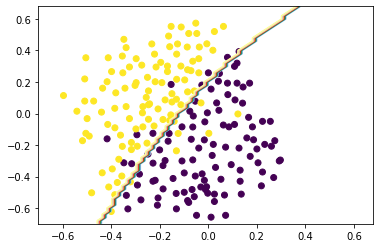

In [25]:
plt.scatter(raw_df["X1"], raw_df["X2"], c=raw_df["Y"])
plt.contour(xx1, xx2, res.reshape(xx1.shape), cmap=plt.cm.Paired)

The curve now fits the data much better and is a (slight) curve, rather than a straight line. 